In [1]:
import torch
import torchvision # 常用数据集包
import torchvision.transforms as transforms # 数据转归一化

In [2]:
transform = transforms.Compose( # 自定义一个转换器,先变成张量,再归一化(每个通道的均值序列,标准差序列)
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # (0-0.5)/0.5 = -1

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, 
                                         transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True,
                                         num_workers=2)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True,
                                       transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False,
                                        num_workers=2)
# num_workers根据计算机的CPU和内存来设置,充足可以设置多一些
# 设为0表示不用内存

classes = ('plane','car', 'bird','cat','deer', 'dog','frog','horse','ship','truck')


Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


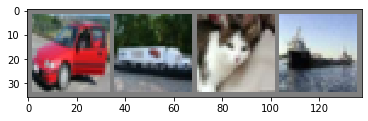

  car truck   cat  ship


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 展示图片
def imshow(img):
    img = img / 2 + 0.5 # 逆归一化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# 获取一些图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.size())

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss() # 交叉熵
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # 设置了动量的SGD

In [11]:
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # 从下标0开始迭代
        inputs, labels = data # 读取数据
        optimizer.zero_grad() # 初始梯度
        outputs = net(inputs) # 前向传播
        loss = criterion(outputs, labels) # 计算交叉熵
        loss.backward() # 反向传播
        optimizer.step() # 优化算法,学习参数
        
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 2.193
[1,  4000] loss: 1.864
[1,  6000] loss: 1.660
[1,  8000] loss: 1.559
[1, 10000] loss: 1.514
[1, 12000] loss: 1.468
[2,  2000] loss: 1.384
[2,  4000] loss: 1.356
[2,  6000] loss: 1.325
[2,  8000] loss: 1.317
[2, 10000] loss: 1.295
[2, 12000] loss: 1.271
Finished Training


In [16]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH) # 保存字典到指定文件

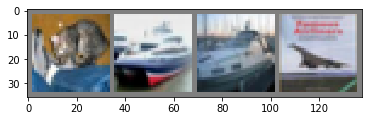

  cat  ship  ship plane


In [15]:
dataiter = iter(testloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [17]:
net = Net()
net.load_state_dict(torch.load(PATH))# 先加载数据,再将数据加载到net里,非必须

<All keys matched successfully>

In [18]:
outputs = net(images) # 使用训练后的数据,进行预测输出
_, predicted = torch.max(outputs, 1) # torch.max(data, dim)获取dim维向量的最大值,返回value,index
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat   car  ship plane


In [19]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 54 %


In [26]:
class_correct = list(0. for i in range(10)) # 10个 0.
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images,labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze() # 将结果压缩一个维度
        for i in range(4): # 批量为4
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 57 %
Accuracy of   car : 52 %
Accuracy of  bird : 41 %
Accuracy of   cat : 44 %
Accuracy of  deer : 27 %
Accuracy of   dog : 40 %
Accuracy of  frog : 69 %
Accuracy of horse : 56 %
Accuracy of  ship : 77 %
Accuracy of truck : 75 %


In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [30]:
net.to(device) # 所有的模块和参数都会递归的变成CUDA张量
inputs, labels = data[0].to(device), data[1].to(device) # 所有数据都需要在GPU